# Class 2

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1/main/Datasets/kc_house_data.csv')
df.head()

In [ ]:
# displaying the first/last 11 columns
df.iloc[0:10,:11].head()
df.iloc[:,11:].head()

In [ ]:
# univariate analysis
df.describe()

# understand the output itself
sns.histplot(df['price'])
plt.hist(df['price'])

# cleaning a specific data point or value
df['bedrooms'] = df['bedrooms'].replace(33, 3) # replacing 33 with 3

In [ ]:
# finding the specific row
df.loc[15870]
# setting specific condition
sns.boxplot(df['bathrooms'])
df[df['bathrooms'] > 3.5].describe()
sns.boxplot(df[df['bathrooms'] > 3.5]['bathrooms'])
sns.boxplot(df[df['bathrooms'] > 3.5]['price'])
# winsorize outliers
values_to_replace_max = df[df['bathrooms'] > 3.5].index
df.loc[values_to_replace_max,'bathrooms'] = 3.5
df[df['bathrooms'] > 3.5]

In [ ]:
# boxplot with categories, x = category
sns.boxplot(x=df['view'], y=df['price'])

In [ ]:
pip install scipy
from scipy import stats
sns.boxplot(df['sqft_living'])
# another way to winsorize
df['sqft_living_winsorized'] = stats.mstats.winsorize(df['sqft_living'], limits=[0,0.01])
df[['sqft_living','sqft_living_winsorized']].sort_values('sqft_living', ascending=False)

In [ ]:
# heatmap
plt.figure(figsize = (20,20))
sns.heatmap(df.iloc[:,2:].corr(), annot=True)

# pairplot
sns.pairplot(df.iloc[:,2:])

# Class 3

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1/main/Datasets/kc_house_data.csv')
df.head()
# info() gives you structural information about the dataset
df.info()

In [ ]:
df['date'] = pd.to_datetime(df['date'])
# how volume changes over time (sort_index to sort with time)
df.groupby('date')['price'].count().sort_index().plot()
df.groupby('date')['price'].sum().sort_index().plot()
# looking at average overtime
df['price_per_sqft'] = df['price'] / df['sqft_living']
df.groupby('date')['price_per_sqft'].mean().sort_index().plot()

#identify the higher average price sold
df.groupby('date')['price_per_sqft'].mean().sort_values()

In [ ]:
#find the size of the particular high price house 
df.set_index('date').loc['2014-08-30']
# look at the usual price sold for the same size, identidy why the high price
df[(df['sqft_living'] >= 1000) & (df['sqft_living']<=1100)]['price'].mean()

In [ ]:
df[(df['sqft_living'] >= 1000) & (df['sqft_living']<=1100)]['price'].mean()
# look at the usual price sold for the same size, identidy why the high price
avg_price_zipcode = df.groupby(['zipcode'])['price_per_sqft'].mean().to_dict()
# average by zipcode
df['zip_price_per_sqft'] = df['zipcode'].map(avg_price_zipcode)
# creates a new column mapped with zipcode, showing the avergae price corresponded to the zipcode
df['compared_to_avg'] = df['price_per_sqft'] - df['zip_price_per_sqft']
sns.boxplot(df['compared_to_avg'])
#above/below the quantile are overpaid/underpaid 

In [ ]:
def value(x):
    if x > 0:
        return 'bad investment'
    elif x == 0:
        return 'fair investment'
    else:
        return 'good investment'
df['investment_type'] = df['compared_to_avg'].apply(value)
# apply single column tranformation using the function just created

In [ ]:
def value_v2(row):
    if row['compared_to_avg'] > 0 and row['grade'] > 10:
        return 'fair investment for a luxury property'
    elif row['compared_to_avg'] > 0 and row['grade'] < 10:
        return 'overpaid'
    elif row['compared_to_avg'] < 0 and row['grade'] > 10:
        return 'really good deal'
    else:
        return 'average deal'
df['deal_evaluation'] = df.apply(value_v2, axis = 1) 
# applied to the whole dataframe because using two or more columns in the function

In [ ]:
#Using the new features we created, what insights can you find in the data? For example, what type of homes tend to be over/underpriced?
#How could you adjust the price_per_sqft calculation to take into account recency of sale? Try building a function -- then repeat your analysis. Any changes?

# waterfront vs deal evaluation
# Group by ColumnX and count occurrences in ColumnY
count_df = df.groupby(['waterfront','deal_evaluation']).size().reset_index(name='Count' )

# Calculate the total counts for each ColumnX category
total_counts = df['waterfront'].value_counts().reset_index()
total_counts.columns = ['waterfront', 'TotalCount']

# Merge the total counts with the grouped counts
count_df = count_df.merge(total_counts, on='waterfront')

# Calculate the percentage
count_df['Percentage'] = (count_df['Count'] / count_df['TotalCount']) * 100
count_df

In [ ]:
# insight: house with 1 bedroom is most overpriced; house with 10 bed is most underpriced
df.groupby('bedrooms')['compared_to_avg'].mean().sort_index()

In [ ]:
df['price_per_floor'] = df['price'] / df['floors']
df.groupby('floors')['price_per_floor'].mean()
df.groupby('date')['price_per_floor'].mean().sort_index().plot()

sns.boxplot(x='floors', y='price', data=df) # with respect to floor number

In [ ]:
# getting avg bedroom price
avg_bedroom_price = df.groupby('bedrooms')['price_per_sqft'].mean().to_dict()
df['avg_bedroom_price'] = df['bedrooms'].map(avg_bedroom_price)
def bedroom_price(row):
    if row['price_per_sqft'] > row['avg_bedroom_price']: 
        return 'Overpaid Investment'
    elif row['price_per_sqft'] < row['avg_bedroom_price']: 
        return 'Underpaid Investment'
    else:
        return 'Average Investment'
df['Money_investment'] = df.apply(bedroom_price, axis =1)
df

df.groupby('Money_investment').count()

df.groupby(['Money_investment','zipcode'])['price'].mean().to_frame().reset_index()\
    .sort_values(by=['zipcode','Money_investment','price'], ascending=[True,True,False])

In [ ]:
def rolling_avg(group):
    group = group.sort_values('date')
    rolling_avg = group.set_index('date')['price_per_sqft'].rolling('90D').mean().shift()
    group['rolling_avg'] = rolling_avg.values
    return group

df = df.groupby('zipcode').apply(rolling_avg).reset_index(drop=True)

df[df['zipcode']==98001].sort_values('date')

df['above/below'] = df['price_per_sqft'] - df['rolling_avg']
sns.boxplot(df['above/below'])

# Class 4

In [ ]:
data = np.random.normal(loc=50, scale=10, size=1000)
plt.hist(data, bins=50, alpha=0.7, color='blue')

stats.probplot(data, dist='norm', plot=plt)

# printing skewness
print(stats.skew(data))
print(stats.kurtosis(data, fisher=True))

In [ ]:
# poisson distribution
from scipy.stats import poisson
data = poisson.rvs(mu=10, size=1000)

plt.hist(data, bins=30, alpha=0.7, color='green')

# exponential distribution
data = np.random.exponential(scale=30, size=1000)

plt.hist(data, bins=50, color='red')

# beta distribution - proportions, naturally bounded distribution 0-1

from scipy.stats import beta

data = beta.rvs(a=2, b=5, size=1000)

plt.hist(data, bins=30)

# Class 7

In [ ]:
pip install statsmodels
pip install scikit-learn
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

bikes = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1/main/Datasets/bikes_sharing.csv')
bikes.head()

In [ ]:
# feature engineering
# create daily version of data set
# convert the datetime column into a datetime data type
bikes.info()
bikes['datetime'] = pd.to_datetime(bikes['datetime'])

In [ ]:
# set the datetime as an index
bikes_daily = bikes.set_index('datetime')
bikes_daily = bikes_daily.resample('D').aggregate({'season':'max', 'holiday':'max','workingday':'max', 'weather':'max',\
                                                   'temp':'mean', 'atemp':'mean', 'humidity':'mean', 'windspeed':'mean',\
                                                    'casual':'sum', 'registered':'sum', 'count':'sum'})
bikes_daily

# isolate the hour of the day to assess time of day
bikes['hour'] = bikes['datetime'].apply(lambda x: x.hour)

In [ ]:

def time_of_day(x):
    if x >= 6 and x <= 9:
        return 'morning_commute'
    elif x > 9 and x <= 15:
        return 'midday'
    elif x > 15 and x <= 19:
        return 'evening_commute'
    else:
        return 'afterhours' 
    
bikes['time_of_day'] = bikes['hour'].apply(time_of_day)

# return the weekday > day 0 = Monday
bikes['weekday'] = bikes['datetime'].apply(lambda x: x.weekday())

In [ ]:
# evaluate weekday vs number of casual or registered or total rentals
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (10,5), sharey=True)
sns.boxplot(x='weekday', y='casual', data=bikes, ax=ax1, palette='tab10')
sns.boxplot(x='weekday', y='registered', data=bikes, ax=ax2, palette='tab10')
sns.boxplot(x='weekday', y='count', data=bikes, ax=ax3, palette='tab10')

# evaluate time_of_day vs number of casual or registered or total rentals
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (10,5), sharey=True)
sns.boxplot(x='time_of_day', y='casual', data=bikes, ax=ax1, palette='tab10')
sns.boxplot(x='time_of_day', y='registered', data=bikes, ax=ax2, palette='tab10')
sns.boxplot(x='time_of_day', y='count', data=bikes, ax=ax3, palette='tab10')

ax2.set_ylabel('registered')
ax3.set_ylabel('count')

In [ ]:
bikes[bikes['time_of_day']=='evening_commute']['casual'].describe()
# evaluate weekday & time_of_day vs number of casual or registered or total rentals
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (25,10), sharey=True)
sns.boxplot(x='weekday', y='casual', hue='time_of_day',data=bikes, ax=ax1, palette='tab10')
sns.boxplot(x='weekday', y='registered', hue='time_of_day',data=bikes, ax=ax2, palette='tab10')
sns.boxplot(x='weekday', y='count', hue='time_of_day',data=bikes, ax=ax3, palette='tab10')

In [ ]:
# lets look at Temperature vs. Rental Counts, add Weekday as a categorical element
# evaluate weekday & time_of_day vs number of casual or registered or total rentals
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (25,10), sharey=False)
sns.scatterplot(x='temp', y='casual', hue='weekday',data=bikes, ax=ax1, palette='tab10')
sns.scatterplot(x='temp', y='registered', hue='weekday', data=bikes, ax=ax2, palette='tab10')
sns.scatterplot(x='temp', y='count', hue='weekday', data=bikes, ax=ax3, palette='tab10')

In [ ]:
# temp, weekday, time_of_day
# for categoricals, they need to be converted into dummy variables
# get_dummies()

model_data = pd.get_dummies(data = bikes[['casual','temp','weekday','time_of_day']], columns=['weekday','time_of_day'], dtype=int)

In [ ]:
model = ols("casual ~ temp +  weekday_1 + weekday_2 + weekday_3 + \
       weekday_4 + weekday_5 + weekday_6  + \
            time_of_day_evening_commute + time_of_day_midday + time_of_day_morning_commute", data=model_data).fit()
print(model.summary())

In [ ]:
predictions = model.predict(model_data.iloc[:,1:])
model.params

final_data = pd.concat([model_data, predictions], axis=1)
final_data.rename(columns={0:'predictions'}, inplace=True)
final_data['residuals'] = final_data['predictions'] - final_data['casual']
# predicted vs residuals
# checking for normality

sns.scatterplot(x='predictions', y='residuals', data=final_data)
# check for normal distribution of residuals
sns.histplot(final_data['residuals'])

In [ ]:
import statsmodels.api as sm
sm.graphics.influence_plot(model, criterion = 'cooks')

# Class 8

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, PrecisionRecallDisplay, precision_score, recall_score, roc_auc_score, RocCurveDisplay, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression


df=pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/diabetes_data.csv')
df.head()

# pairplot
sns.pairplot(df, hue='Outcome')
# heatmap
sns.heatmap(df.iloc[:,:8].corr(), annot=True, vmin=-1, vmax=1)

In [ ]:
# checking for imbalance
model_data['Outcome'].value_counts()
model_data.groupby('Outcome')['Pregnancies'].count()/len(model_data)

# spliting training/testing data
train, test = train_test_split(model_data, test_size=0.3, random_state=1234)

In [ ]:
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'Insulin', 'BMI',
       'DiabetesPedigreeFunction', 'Age']
target = 'Outcome'
# cross validation 
scores = cross_val_score(LogisticRegression(), train[features], train[target], cv=5, scoring='accuracy')

# calculate average score
np.mean(scores)
0.762895622895623
logreg = LogisticRegression().fit(train[features], train[target])
logreg.coef_

y_pred = logreg.predict(test[features])
y_pred

pd.Series(test[target])
# checking target
np.array(test[target]).ravel()

In [ ]:
final_scores = pd.DataFrame([test[target].to_list(), y_pred]).T.rename(columns={0:'Actual',1:'Predicted'})
final_scores['difference'] = final_scores['Actual'] - final_scores['Predicted']
final_scores[final_scores['difference']!=0].count() / len(final_scores)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test[target], y_pred)

# # 2nd / 1st are FALSE NEGATIVES > the model predicted they do NOT have diabetes, even though they do
final_scores[final_scores['Actual'] == 1].count()
final_scores[(final_scores['Actual'] == 1)&(final_scores['difference'] != 0)].count()

# getting the confusion matrix
sns.heatmap(confusion_matrix(test[target], y_pred), annot=True)
plt.ylabel('True Classes')
plt.xlabel('Predicted Classes')
# False Positive: predicted 1 but actual 0
# False Negative: Predicted 0 but actual 1
# True Postive: predicted 1 and actual 1
# True Negative: predicted 0 and actual 0

# Precision
# TRUE POSITIVES / (TRUE POSITIVES + FALSE POSITIVES)
precision_score(test[target],y_pred)

# Recall
# TRUE POSITIVES / (TRUE POSITIVES + FALSE NEGATIVES)
recall_score(test[target],y_pred)

# F1 Score
# (2*TRUE POSITIVES) / (2*TP + FP + FN)
f1_score(test[target],y_pred)

# Precision Recall Curve, trade-off between precison and recall
display = PrecisionRecallDisplay.from_estimator(logreg, test[features], test[target])

In [ ]:
probs = logreg.predict_proba(test[features])
# use 70% threshold
new_predictions =[]
for i in probs[:,1]:
    if i >= 0.7:
        new_predictions.append(1)
    else:
        new_predictions.append(0)
sns.heatmap(confusion_matrix(test[target], new_predictions), annot=True)
plt.ylabel('True Classes')
plt.xlabel('New Predicted Classes')
# this would increase accuracy, but also increase False positive

# tradeoff between True Positive & False Positive Rate
fpr, tpr, thresholds = roc_curve(test[target], probs[:,1])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Class 9

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV #GridSearch is for hyperparameter tuning
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, PrecisionRecallDisplay, RocCurveDisplay

bikes = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1/main/Datasets/bikes_sharing.csv')
bikes.head()

In [ ]:
sns.histplot(bikes['count'])

In [ ]:
# boxplot of usage with repsect to each hour
# the range of count from 15 to 17 is the largets, which is rush hours
sns.boxplot(x='hour', y='count', data=bikes)

In [ ]:
# recreate our time of day values
bikes['datetime'] = pd.to_datetime(bikes['datetime'])
bikes['hour'] = bikes['datetime'].apply(lambda x: x.hour)
# filter for rush hour rentals in the evenings and use that as a proxy for "high number of rentals"
bikes[(bikes['hour'] >= 15) & (bikes['hour']<=19)]['count'].mean()
# 357.11491228070173
bikes['binary_output'] = bikes['count'].apply(lambda x: 1 if x>=357 else 0)
bikes.groupby('binary_output')['datetime'].count()

In [ ]:
# split data into X variables and y variable
# we are going to predict whether on any given hour, we will rent a HIGH number of bikes (1 = 357+ bikes) OR a LOW number of bikes (0 = <357 bikes)
X = bikes[['season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'hour']]
y = bikes['binary_output']
# reserve 30% for testing
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [ ]:
# demonstrate what MinMaxScaler() does, standardize between 0 and 1
MinMaxScaler().fit_transform(bikes[['temp',
       'atemp', 'humidity', 'windspeed']])

In [ ]:
# demonstrate OHE
OneHotEncoder().fit_transform(bikes[['season', 'holiday', 'workingday']])

# build our pipeline that includes these transformations
numeric_columns = ['temp','atemp', 'humidity', 'windspeed']
categorical_columns = ['season', 'holiday', 'workingday', 'weather']
# create a pre-processing pipeline which includes the steps of Scaling numeric variables and encoding categoricals
preprocessor = ColumnTransformer(
    transformers=[
        ('num',MinMaxScaler(), numeric_columns),
        ('cat',OneHotEncoder(handle_unknown='ignore'),categorical_columns)
    ]
)

In [ ]:
# we are going to test 3 models with cross validation to see which ones work best for this data
knn = KNeighborsClassifier()
logreg = LogisticRegression()
nb = GaussianNB()
# cross validation to determine in general which model works best for the given problem
knn_scores = cross_val_score(knn, X_train, y_train, scoring='f1', cv=5)
logreg_scores = cross_val_score(logreg, X_train, y_train, scoring='f1', cv=5)
nb_scores = cross_val_score(nb, X_train, y_train, scoring='f1', cv=5)

print(np.mean(knn_scores))
print(np.mean(logreg_scores))
print(np.mean(nb_scores))

In [ ]:
# build our pipeline
pipeline = Pipeline(steps=
                    [
                        ('preprocessor',preprocessor),
                        ('classifier',KNeighborsClassifier())
                    ])
# a quick side-quest demo of how KNN works
knn_15 = KNeighborsClassifier(n_neighbors=15).fit(X_train,y_train)
pred_15 = knn_15.predict(X_test)
print(accuracy_score(y_test, pred_15))
print(f1_score(y_test, pred_15))
print(precision_score(y_test, pred_15))
print(recall_score(y_test, pred_15))

# a quick side-quest demo of how KNN works
knn_30 = KNeighborsClassifier(n_neighbors=30).fit(X_train,y_train)
pred_30 = knn_30.predict(X_test)
print(accuracy_score(y_test, pred_30))
print(f1_score(y_test, pred_30))
print(precision_score(y_test, pred_30))
print(recall_score(y_test, pred_30))

In [ ]:
# hyperparameter tuning
# KNN has several hyperparameters we can tune
# n_neighbors, weights, metric, algorithm
# use GRID SEARCH to find the best combination of hyperparameters for our problem
param_grid = {
    'classifier__n_neighbors':[5,7,9,15,35,45,55],
    'classifier__weights':['uniform','distance'],
    'classifier__metric':['euclidean','manhattan','minkowski']
}
# let's perform gridsearch
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, scoring='f1')
grid_search.fit(X_train,y_train)

In [ ]:
# the best parameters
print(grid_search.best_params_)

# final pipeline
final_classifier = KNeighborsClassifier(n_neighbors=grid_search.best_params_['classifier__n_neighbors'],
                                        metric = grid_search.best_params_['classifier__metric'],
                                        weights = grid_search.best_params_['classifier__weights']
                                        )
final_pipeline = Pipeline(steps=
                          [
                              ('preprocessor',preprocessor),
                              ('classifier',final_classifier)
                          ])
final_pipeline.fit(X_train,y_train)

In [ ]:
pred = final_pipeline.predict(X_test)
probs = final_pipeline.predict_proba(X_test)
f1_score(y_test, pred)
accuracy_score(y_test,pred)
precision_score(y_test,pred)
recall_score(y_test,pred)

# Class 10

In [2]:
#SVM demo

from sklearn.svm import SVC
from matplotlib import pyplot as plt
import numpy as np
import sklearn

theme = 'seismic'

from sklearn.datasets import make_blobs

In [3]:
X, y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=1.3)
y

array([1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 0])

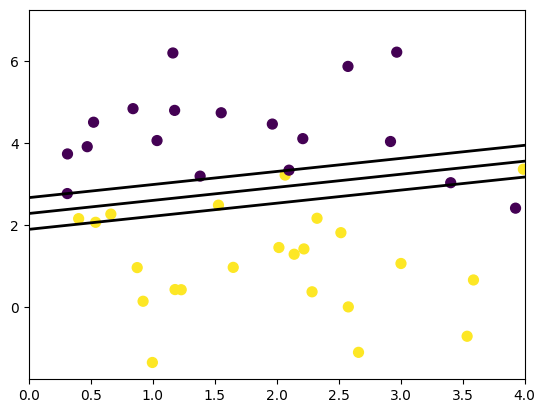

In [4]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]
    margin = 1/w[1]
    gutter_up = decision_boundary+margin
    gutter_down = decision_boundary-margin
    svs = svm_clf.support_vectors_
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k-", linewidth=2)
    plt.plot(x0, gutter_down, "k-", linewidth=2)

plt.scatter(X[:,0], X[:,1], c=y, s=50)

svm_clf = SVC(kernel='linear', C=100)
svm_clf.fit(X,y)

plt.xlim(0,4)
plot_svc_decision_boundary(svm_clf,0,4)

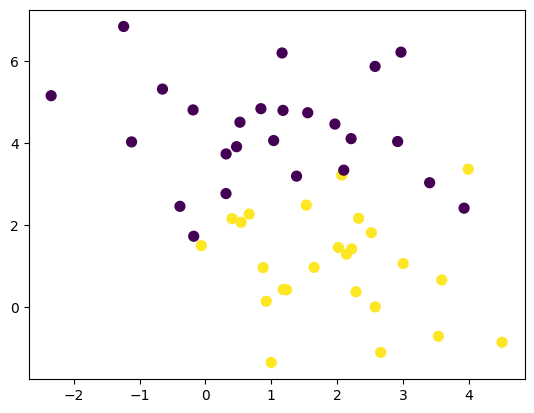

In [5]:
plt.scatter(X[:,0], X[:,1], c=y, s=50)

In [6]:
svm_clf = SVC(kernel='linear', C=100)
svm_clf.fit(X,y)

SVC(C=100, kernel='linear')

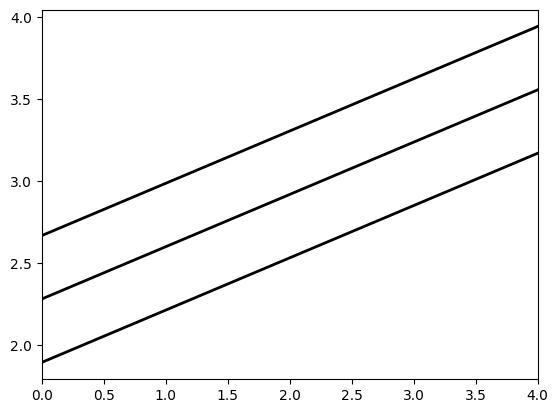

In [7]:
plt.xlim(0,4)
plot_svc_decision_boundary(svm_clf,0,4)

In [8]:
svm_clf.predict(X)

array([1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 0])

In [9]:
from sklearn.datasets import load_iris
data = load_iris()
X,y = data.data[:, (2,3)], data.target
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

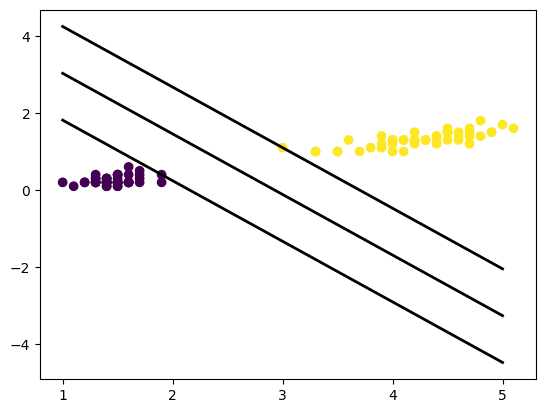

In [10]:
setosa_and_versicolor = (y==0) | (y==1)

X = X[setosa_and_versicolor]
y = y[setosa_and_versicolor]
plt.scatter(X[:,0], X[:,1], c=y, marker='o')

svm_clf = SVC(kernel='linear', C=100)
svm_clf.fit(X,y)

plot_svc_decision_boundary(svm_clf, 1,5)

In [ ]:
# polynomial kernel
from sklearn.datasets import make_moons
X,y = make_moons(n_samples=100, noise=0.2)
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap='seismic', alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap='seismic', alpha=0.1)
plt.scatter(X[:,0], X[:,1], c=y, cmap='seismic')
svm_clf = SVC(kernel='poly', degree=9, coef0=7, C=1000)
svm_clf.fit(X,y)
plot_predictions(svm_clf, [-1.5, 2.5, -1, 1.5])

In [ ]:
# RBF kernel

X,y = make_moons(n_samples=100, noise=0.2)
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=theme, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=theme, alpha=0.1)
plt.scatter(X[:,0], X[:,1], c=y, cmap='seismic')

svm_clf = SVC(kernel='rbf', gamma=100, C=20)
svm_clf.fit(X,y)
plot_predictions(svm_clf, [-1.5, 2.5, -1, 1.5])

In [ ]:
plt.scatter(X[:,0], X[:,1], c=y, cmap='seismic')

svm_clf = SVC(kernel='rbf', gamma=0.4, C=20)
svm_clf.fit(X,y)

plot_predictions(svm_clf, [-1.5, 2.5, -1, 1.5])

In [ ]:
# SVM REGRESSION

from sklearn.svm import LinearSVR
np.random.seed(50)
m=100
X=3*np.random.rand(m,1)
y=(5+2*X+np.random.randn(m,1)).ravel()
def plot_svm_regression(svm_reg, X,y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100,1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2)
    plt.plot(x1s, y_pred + svm_reg.epsilon, 'k--')
    plt.plot(x1s, y_pred - svm_reg.epsilon, 'k--')
    plt.plot(X,y,'bo')
    plt.axis(axes)
svm_reg = LinearSVR(epsilon=0.3)
svm_reg.fit(X,y)
plot_svm_regression(svm_reg, X,y, [0,2,3,11])

In [ ]:
import pandas as pd
bikes = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1/main/Datasets/bikes_sharing.csv')
bikes.head(
    
)

In [ ]:
X = bikes[['temp','atemp','humidity','windspeed']]
y = bikes['count']
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y)
linreg = LinearRegression()
reg_model = linreg.fit(X_train,y_train)
pred = reg_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, pred))

lin_SVR = LinearSVR(epsilon=10)
linsvr = lin_SVR.fit(X_train,y_train)
pred2 = linsvr.predict(X_test)

np.sqrt(mean_squared_error(y_test, pred2))

In [ ]:
params = {'epsilon':np.linspace(0,1,10),
          'max_iter':[1000,5000,10000]}
random_search = RandomizedSearchCV(estimator=linsvr,
                                   param_distributions=params,
                                   n_iter=50,
                                   scoring='neg_mean_absolute_error',
                                   cv=5)
random_search.fit(X_train, y_train)

In [ ]:
random_search.best_params_
bikes['binary_output'] = bikes['count'].apply(lambda x: 1 if x >= 145 else 0)
svc = SVC()
params = {
    'C':np.linspace(1,4,20),
    'gamma': np.linspace(1,4,20),
    'kernel':['linear','rbf','poly']

}

In [ ]:
#random_search.fit(X_train, y_train)
#random_search.best_params_
data = load_iris()
X,y = data.data[:, (2,3)], data.target
setosa_and_versicolor = (y==0) | (y==1)

X = X[setosa_and_versicolor]
y = y[setosa_and_versicolor]
params = {
    'C':np.logspace(-4,4,20),
    'gamma': np.logspace(-4,4,20),
    'kernel':['linear','rbf','poly']

}
random_search = RandomizedSearchCV(
    estimator=svc,
    param_distributions=params,
    n_iter=50,
    scoring='accuracy',
    cv=5
)

X_train, X_test, y_train, y_test = train_test_split(X,y)
random_search.fit(X_train, y_train)

random_search.best_estimator_

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

pipeline = Pipeline(steps=
                    [
                        ('preprocessor',preprocessor),
                        ('classifier',KNeighborsClassifier())
                    ])

knn_15 = KNeighborsClassifier(n_neighbors=15).fit(X_train,y_train)
pred_15 = knn_15.predict(X_test)
print(accuracy_score(y_test, pred_15))
print(f1_score(y_test, pred_15))
print(precision_score(y_test, pred_15))
print(recall_score(y_test, pred_15))